In [10]:
from numpy.core.defchararray import index
import scipy
import scipy.stats as sps
import cvxpy as cp
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


Реализуем следующий алгоритм:

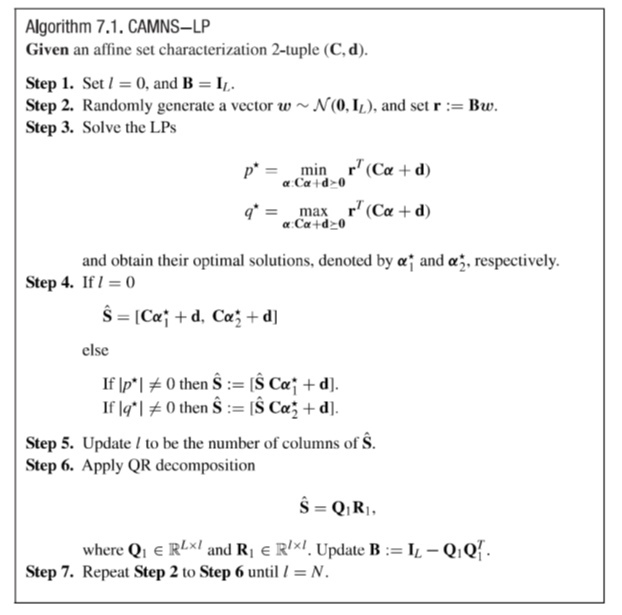

Где C, d возьмем следующие:

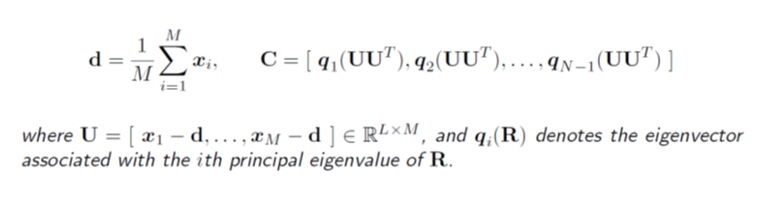

In [36]:
def download(path, sources):
    images = []
    for i, source in enumerate(sources):
        image = np.asarray(Image.open(path + source).convert('L'))
        w, h = np.shape(image)
        image = image.flatten()
        images.append(image)

    return images, w, h

def mix(sources, coef):
    plt.figure(figsize=(12, 8))
    images = []
    for source in sources:
        image = np.asarray(Image.open('img/' + source).convert('L'))
        print(image.shape)
        w, h = np.shape(image)
        images.append(image.flatten())

    images = np.array(images)
    for i in range(len(coef)):
        mix = coef[i] @ images
        mix = mix.reshape(w, h)
        im = Image.fromarray(np.uint8(mix))
        im.save(f'img/mix/mix{i}.jpg')
        ax = plt.subplot(1, 3, i + 1)
        ax.imshow(im, cmap='gray')
    plt.show()
    

def show_result(S, h, w):
    plt.figure(figsize=(15, 10))
    S = S.T
    N = np.shape(S)[0]
    for i in range(N):
        img = S[i].copy()
        img = img.reshape(w, h)
        im = Image.fromarray(np.uint8(img))
        im.save(f'img/res/res{i}.jpg')
        ax = plt.subplot(1, N, i + 1)
        ax.imshow(im, cmap='gray')
    plt.show()

In [44]:
def CAMNS_LP(X, N=3):
    eps = 1e-3

    L, M = np.shape(X)
    print(L, M)
    
    d = X.mean(axis=1).reshape(-1, 1)
    U = X - np.tile(d, (1, X.shape[1]))
    d = d.flatten()
    C = U[:, :N-1]

    el = 0
    Q1 = np.zeros(L)
    hS = []
    lp_cnt = 0
    B = np.eye(L)
    while el < N:
        w = sps.norm.rvs(size=L)
        r = B @ w
        
        alpha = cp.Variable(np.shape(C)[1])
        prob = cp.Problem(cp.Minimize(r.T @ (C@alpha + d)),
                 [C@alpha + d >= 0])
        p_star = prob.solve()
        alpha1 = alpha.value.copy()
        
        alpha = cp.Variable(np.shape(C)[1])
        prob = cp.Problem(cp.Maximize(r @ (C@alpha + d)),
                 [C@alpha + d >= 0])
        q_star = prob.solve()
        alpha2 = alpha.value.copy()
        
        s1 = C@alpha1 + d
        s2 = C@alpha2 + d
       
        if el == 0:
            if abs(p_star) >= eps and abs(q_star) >= eps:
                S_hat = np.column_stack((s1, s2))
            elif abs(p_star) >= eps:
                S_hat = s1.copy()
            elif abs(q_star) >= eps:
                S_hat = s2.copy()
            
        else:
            if abs(p_star) >= eps:
                S_hat = np.column_stack((S_hat, s1))
            
            if abs(q_star) >= eps:
                S_hat = np.column_stack((S_hat, s2))
        el = np.shape(S_hat)[1]
        Q, R = np.linalg.qr(np.array(S_hat))
        B = np.eye(L) - Q @ Q.T
        
    return S_hat


Замиксуем изображения:

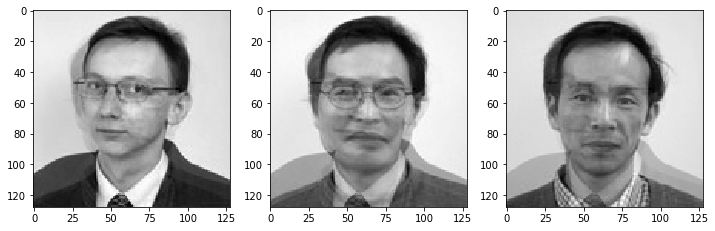

In [5]:
A = np.array([
    [0.2, 0.7, 0.1],
    [0.6, 0.3, 0.1],
    [0.1, 0.2, 0.7]
])
sources = ['cao1.jpg', 'ksiwek1.jpg', 'zhang1.jpg']

mix(sources, A)

Закинем замикшенные картинки в алгоритм:

In [6]:
sources = ['mix0.jpg', 'mix1.jpg', 'mix2.jpg']
path = 'img/mix/'
X, w, h = download(path, sources)
X = np.array(X).T
N = 3
S = CAMNS_LP(X , 3)

16384 3


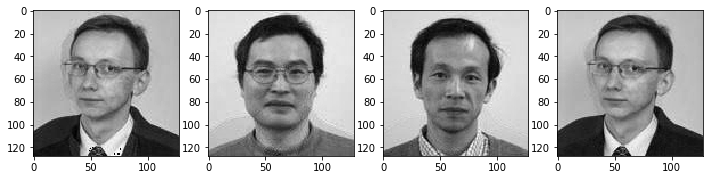

In [7]:
show_result(S, w, h)


Повторим эксперимент с другими картинками:

(128, 95)
(128, 95)
(128, 95)


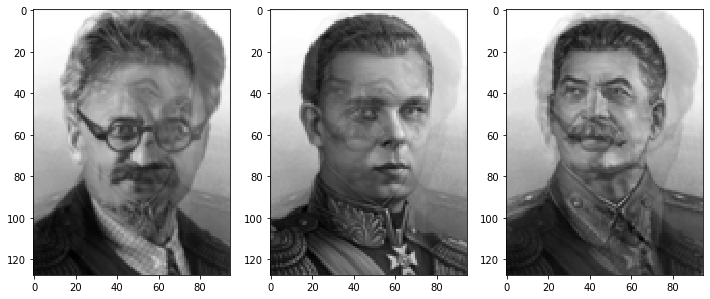

In [50]:
A = np.array([
    [0.2, 0.6, 0.2],
    [0.7, 0.1, 0.2],
    [0.2, 0.2, 0.6]
])
sources = ['Vladimir.png', 'Trotsky.png', 'Stalin.png']

mix(sources, A)

In [51]:
sources = ['mix0.jpg', 'mix1.jpg', 'mix2.jpg']
path = 'img/mix/'
X, w, h = download(path, sources)
X = np.array(X).T
N = 3
S = CAMNS_LP(X , 3)

12160 3


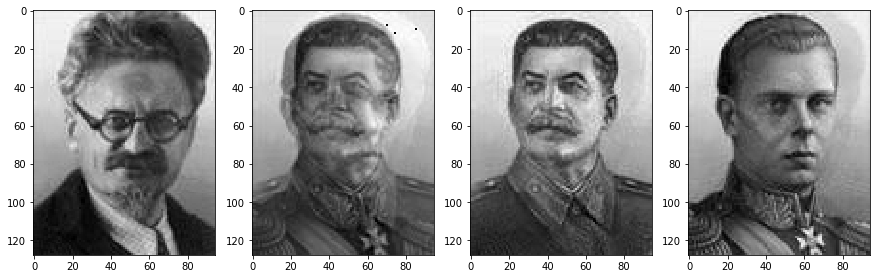

In [52]:
show_result(S, h, w)